In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train_path = '../input/brain-tumor-mri-classification/MRICopy/train'
test_path = '../input/brain-tumor-mri-classification/MRICopy/test'
val_path = '../input/brain-tumor-mri-classification/MRICopy/val'

In [3]:
train_batches = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
train_path, target_size=(224, 224), batch_size=2210)

test_batches = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
test_path, target_size=(224, 224), batch_size=560)

val_batches = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
val_path, target_size=(224, 224), batch_size=820)

Found 2210 images belonging to 4 classes.
Found 560 images belonging to 4 classes.
Found 820 images belonging to 4 classes.


In [4]:
X_train, y_train = next(train_batches)
X_test, y_test = next(test_batches)
X_val, y_val = next(val_batches)

In [5]:
test_batches.image_shape

(224, 224, 3)

In [6]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

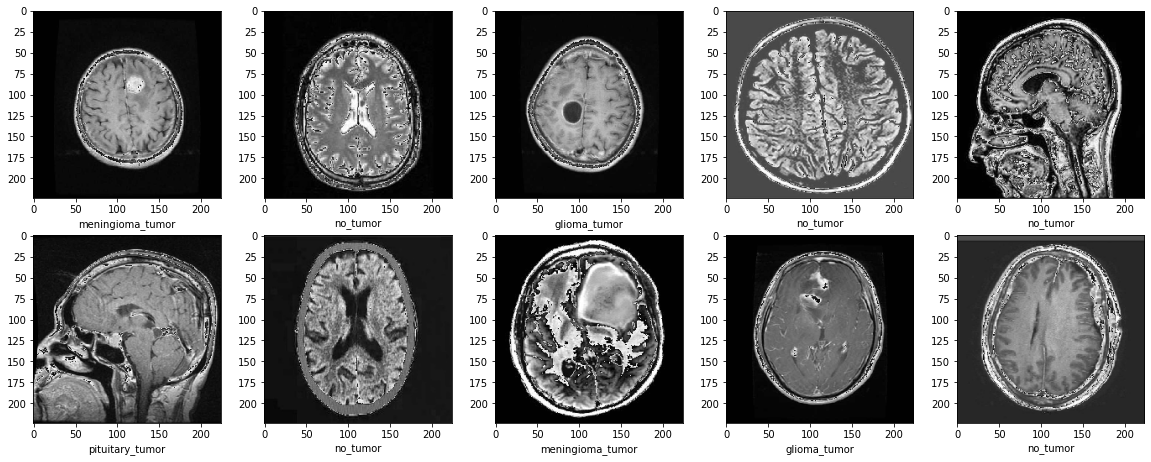

In [7]:
plt.figure(figsize=(20, 20))
for n, i in enumerate(np.random.randint(0, len(X_test), 10)):
    plt.subplot(5, 5, n+1)
    plt.imshow((X_test[i]*255).astype(np.uint8))
    plt.xlabel(labels[np.argmax(y_test[i])])

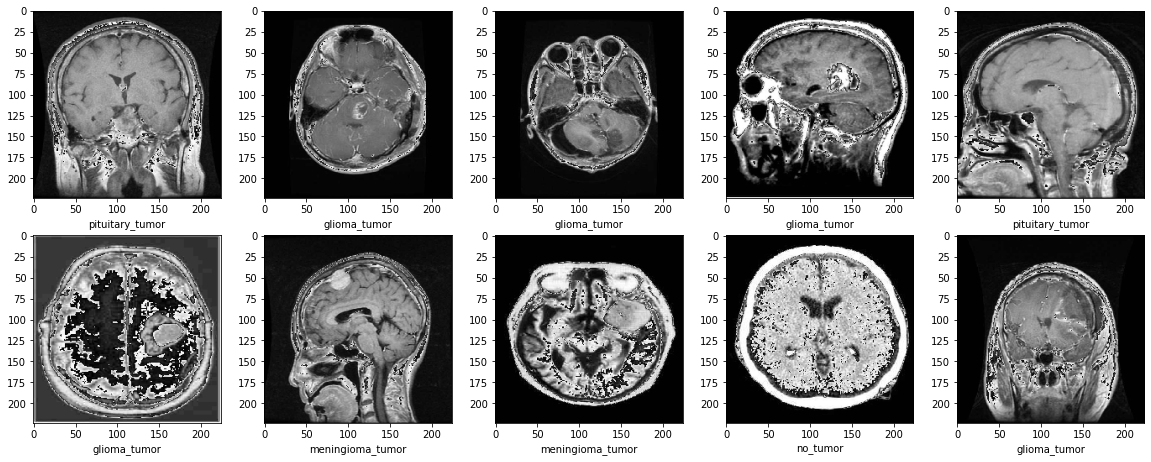

In [8]:
plt.figure(figsize=(20, 20))
for n, i in enumerate(np.random.randint(0, len(X_train), 10)):
    plt.subplot(5, 5, n+1)
    plt.imshow((X_train[i]*255).astype(np.uint8))
    plt.xlabel(labels[np.argmax(y_train[i])])

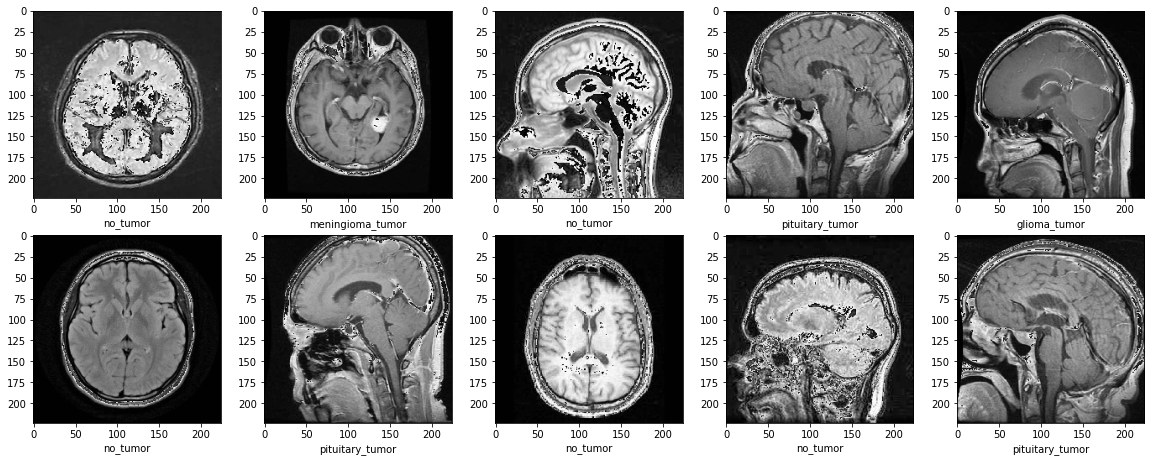

In [9]:
plt.figure(figsize=(20, 20))
for n, i in enumerate(np.random.randint(0, len(X_val), 10)):
    plt.subplot(5, 5, n+1)
    plt.imshow((X_val[i]*255).astype(np.uint8))
    plt.xlabel(labels[np.argmax(y_val[i])])

In [10]:
img_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = img_train_datagen.flow(X_train, y_train, batch_size=30)
valid_generator = img_train_datagen.flow(X_val, y_val)

In [11]:
mobile_net = tf.keras.applications.mobilenet.MobileNet(dropout=0.4)

2023-02-08 01:17:51.721124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 01:17:51.722281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 01:17:51.855829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 01:17:51.856638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 01:17:51.857373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

17235968/17225924 [==============================] - 0s 0us/step


In [12]:
model_mobile = tf.keras.Sequential()
for layer in mobile_net.layers[:-1]:
    model_mobile.add(layer)

In [13]:
for layer in model_mobile.layers:
    layer.trainable = False

In [14]:
model_mobile.add(tf.keras.layers.Dense(4, activation = 'Softmax'))

In [15]:
model_mobile.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pw_1 (Conv2D)           (None, 112, 112, 64)      2

In [16]:
model_mobile.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

In [18]:
history = model_mobile.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size = 60
                           , verbose=1, callbacks=[reduce_lr, early_stopping])

2023-02-08 01:17:56.864025: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1330667520 exceeds 10% of free system memory.
2023-02-08 01:17:58.354888: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1330667520 exceeds 10% of free system memory.
2023-02-08 01:17:59.425454: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2023-02-08 01:18:02.321178: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


37/37 [==============================] - 17s 170ms/step - loss: 2.3602 - accuracy: 0.4864 - val_loss: 0.8734 - val_accuracy: 0.7085
Epoch 2/40
37/37 [==============================] - 3s 90ms/step - loss: 1.2279 - accuracy: 0.6552 - val_loss: 0.6145 - val_accuracy: 0.7695
Epoch 3/40
37/37 [==============================] - 3s 91ms/step - loss: 0.9595 - accuracy: 0.7140 - val_loss: 0.5439 - val_accuracy: 0.8110
Epoch 4/40
37/37 [==============================] - 3s 92ms/step - loss: 0.8996 - accuracy: 0.7149 - val_loss: 0.5864 - val_accuracy: 0.7841
Epoch 5/40
37/37 [==============================] - 3s 91ms/step - loss: 0.8068 - accuracy: 0.7484 - val_loss: 0.4569 - val_accuracy: 0.8280
Epoch 6/40
37/37 [==============================] - 3s 93ms/step - loss: 0.7506 - accuracy: 0.7638 - val_loss: 0.4396 - val_accuracy: 0.8366
Epoch 7/40
37/37 [==============================] - 3s 92ms/step - loss: 0.6291 - accuracy: 0.7923 - val_loss: 0.3980 - val_accuracy: 0.8524
Epoch 8/40
37/37 [====

In [19]:
predictions = model_mobile.predict(X_test, verbose=0)

In [20]:
acc = model_mobile.evaluate(X_test, y_test)
acc

18/18 [==============================] - 1s 35ms/step - loss: 0.3117 - accuracy: 0.8821


[0.31173083186149597, 0.8821428418159485]

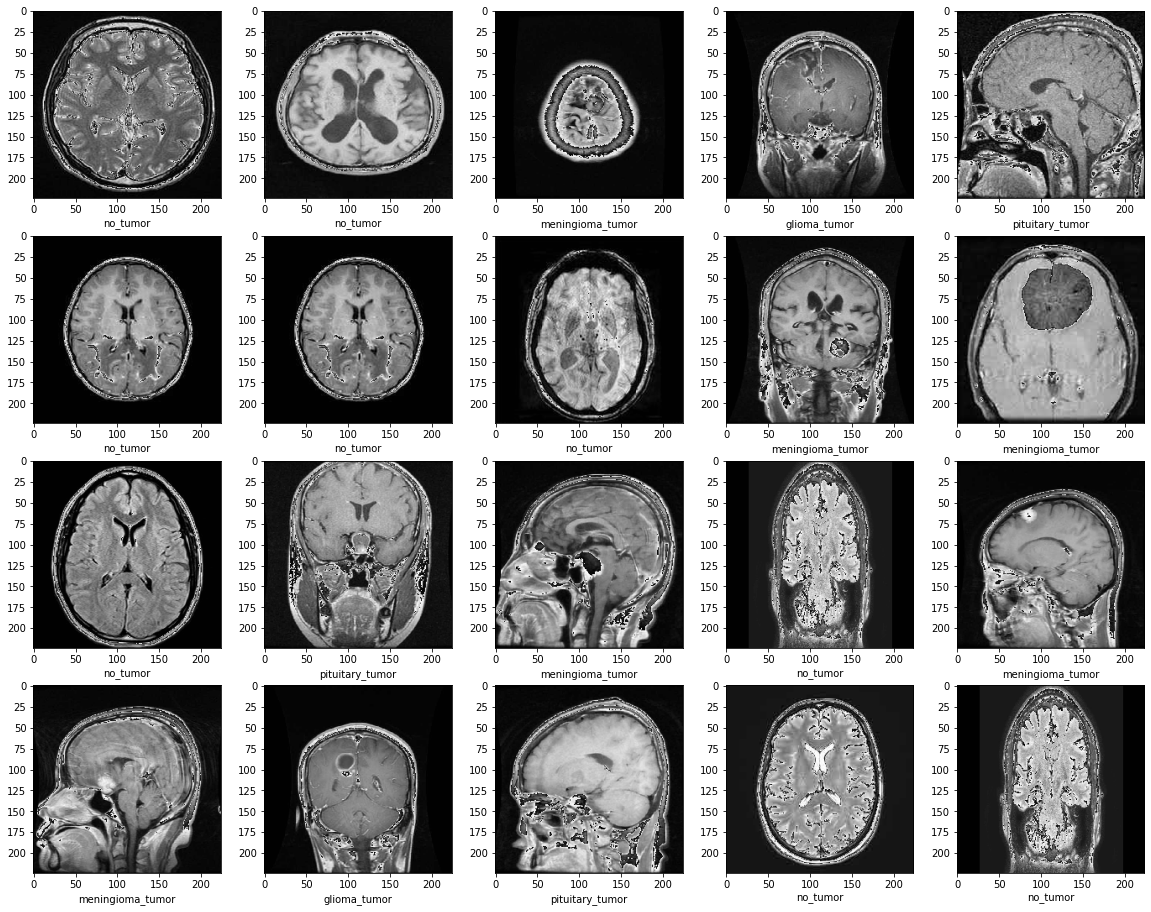

In [21]:
plt.figure(figsize=(20, 20))
for n, i in enumerate(np.random.randint(0, len(predictions), 20)):
    plt.subplot(5, 5, n+1)
    plt.imshow((X_test[i]*255).astype(np.uint8))
    plt.xlabel(labels[np.argmax(y_test[i])])

In [22]:
conf = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

<AxesSubplot:>

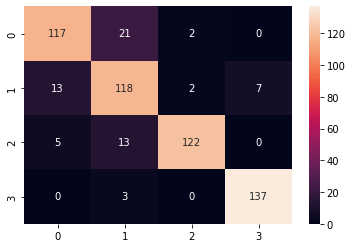

In [23]:
sns.heatmap(conf, annot= True, fmt='d')

In [24]:
clas = classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(clas)

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       140
           1       0.76      0.84      0.80       140
           2       0.97      0.87      0.92       140
           3       0.95      0.98      0.96       140

    accuracy                           0.88       560
   macro avg       0.89      0.88      0.88       560
weighted avg       0.89      0.88      0.88       560



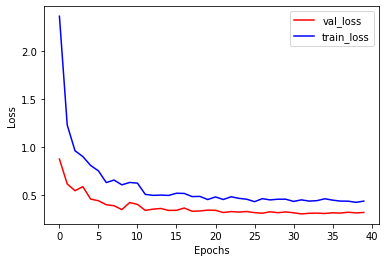

In [25]:
plt.plot(history.history['val_loss'], color='red', label='val_loss')
plt.plot(history.history['loss'], color='blue', label='train_loss')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()

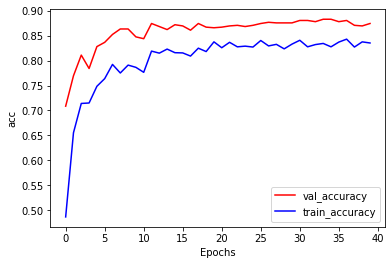

In [26]:
plt.plot(history.history['val_accuracy'], color='red', label='val_accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train_accuracy')
plt.xlabel('Epochs')
plt.ylabel("acc")
plt.legend()